In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer


# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-west-2 region. You will use the 433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [2]:
bucket_name = 'projectdatasetcovid' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [3]:
try:
  urllib.request.urlretrieve ("https://projectdatasetcovid.s3-us-west-2.amazonaws.com/201029COVID19MEXICO.csv","201029COVID19MEXICO.csv")
  print('Success: 201029COVID19MEXICO.csv')
except Exception as e:
  print('Data load error: ',e)

Success: 201029COVID19MEXICO.csv


In [4]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import SQLContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [5]:
#from pyspark.sql import SQLContext
url = "201029COVID19MEXICO.csv"
from pyspark import SparkFiles
sc.addFile(url)
sqlContext = SQLContext(sc)

In [15]:
df = sqlContext.read.csv(SparkFiles.get("201029COVID19MEXICO.csv"), header=True, inferSchema= True)

In [16]:
df.printSchema()

root
 |-- FECHA_ACTUALIZACION: string (nullable = true)
 |-- ID_REGISTRO: string (nullable = true)
 |-- ORIGEN: integer (nullable = true)
 |-- SECTOR: integer (nullable = true)
 |-- ENTIDAD_UM: integer (nullable = true)
 |-- SEXO: integer (nullable = true)
 |-- ENTIDAD_NAC: integer (nullable = true)
 |-- ENTIDAD_RES: integer (nullable = true)
 |-- MUNICIPIO_RES: integer (nullable = true)
 |-- TIPO_PACIENTE: integer (nullable = true)
 |-- FECHA_INGRESO: string (nullable = true)
 |-- FECHA_SINTOMAS: string (nullable = true)
 |-- FECHA_DEF: string (nullable = true)
 |-- INTUBADO: integer (nullable = true)
 |-- NEUMONIA: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- NACIONALIDAD: integer (nullable = true)
 |-- Pregnant: integer (nullable = true)
 |-- HABLA_LENGUA_INDIG: integer (nullable = true)
 |-- Native: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- EPOC: integer (nullable = true)
 |-- ASMA: integer (nullable = true)
 |-- INMUSUPR: integer

In [17]:
import pyspark.sql.functions as F
#df1 = df.withColumnRenamed("TIPO_PACIENTE","Patient_Type")\.withColumnRenamed("SEXO","Sex")

df1 = df.selectExpr("TIPO_PACIENTE as PATIENT_TYPE",
                   "SEXO as SEX",
                   "Age as AGE",
                   "INTUBADO as INTUBED",
                    "NEUMONIA as NEUMONIA",
                    "Pregnant as PREGNANT",
                   "DIABETES as DIABETES",
                  "EPOC as EPOC",
                   "ASMA as ASTHMA",
                   "INMUSUPR as INMUSUPR",
                   "HIPERTENSION as HYPERTENSION",
                   "CARDIOVASCULAR as CARDIOVASCULAR",
                   "OBESIDAD as OBESITY",
                   "RENAL_CRONICA as RENAL_CRONIC",
                   "OTRA_COM as OTHER_DISEASE",
                  "TABAQUISMO as TOBACCO",
                   "OTRO_CASO as CONTACT_OTHER_COVID",
                   "CLASIFICACION_FINAL as CLASSIFICACION_FINAL",
                   "UCI as ICU",
                   "RESULTADO_LAB as LAB_RESULT",
                    "FECHA_DEF as DEATH"
                  )
df1.printSchema()

root
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- INTUBED: integer (nullable = true)
 |-- NEUMONIA: integer (nullable = true)
 |-- PREGNANT: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- EPOC: integer (nullable = true)
 |-- ASTHMA: integer (nullable = true)
 |-- INMUSUPR: integer (nullable = true)
 |-- HYPERTENSION: integer (nullable = true)
 |-- CARDIOVASCULAR: integer (nullable = true)
 |-- OBESITY: integer (nullable = true)
 |-- RENAL_CRONIC: integer (nullable = true)
 |-- OTHER_DISEASE: integer (nullable = true)
 |-- TOBACCO: integer (nullable = true)
 |-- CONTACT_OTHER_COVID: integer (nullable = true)
 |-- CLASSIFICACION_FINAL: integer (nullable = true)
 |-- ICU: integer (nullable = true)
 |-- LAB_RESULT: integer (nullable = true)
 |-- DEATH: string (nullable = true)



In [18]:
from pyspark.sql.functions import col, when

#changed DEATH TO 1 or 0

#If yes ->1, No -> 0 and Missing/NA -> 2
df2 = df1.withColumn("PREGNANT",when(col("PREGNANT") == "2", 0).when(col("PREGNANT") == "1", 1).when(col("SEX") == "2", 0).otherwise(np.nan))
df2 = df2.withColumn("NEUMONIA",when(col("NEUMONIA") == "2", 0).when(col("NEUMONIA") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("INTUBED",when(col("INTUBED") == "2", 0).when(col("INTUBED") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("DIABETES",when(col("DIABETES") == "2", 0).when(col("DIABETES") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("EPOC",when(col("EPOC") == "2", 0).when(col("EPOC") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("ASTHMA",when(col("ASTHMA") == "2", 0).when(col("ASTHMA") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("INMUSUPR",when(col("INMUSUPR") == "2", 0).when(col("INMUSUPR") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("HYPERTENSION",when(col("HYPERTENSION") == "2", 0).when(col("HYPERTENSION") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("OTHER_DISEASE",when(col("OTHER_DISEASE") == "2", 0).when(col("OTHER_DISEASE") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("CARDIOVASCULAR",when(col("CARDIOVASCULAR") == "2", 0).when(col("CARDIOVASCULAR") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("OBESITY",when(col("OBESITY") == "2", 0).when(col("OBESITY") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("RENAL_CRONIC",when(col("RENAL_CRONIC") == "2", 0).when(col("RENAL_CRONIC") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("TOBACCO",when(col("TOBACCO") == "2", 0).when(col("TOBACCO") == "1", 1).otherwise(np.nan))
#leave out contact_other_covid
df2 = df2.withColumn("CONTACT_OTHER_COVID",when(col("CONTACT_OTHER_COVID") == "2", 0).when(col("CONTACT_OTHER_COVID") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("ICU",when(col("ICU") == "2", 0).when(col("ICU") == "1", 1).otherwise(np.nan))
df2 = df2.withColumn("DEATH",when(col("DEATH") == "9999-99-99", 0).otherwise("1"))
df2 = df2.withColumn("LAB_RESULT",when(col("LAB_RESULT") == "2", 0).when(col("LAB_RESULT") == "1", 1).otherwise(np.nan))

df2.show(10);

+------------+---+---+-------+--------+--------+--------+----+------+--------+------------+--------------+-------+------------+-------------+-------+-------------------+--------------------+---+----------+-----+
|PATIENT_TYPE|SEX|AGE|INTUBED|NEUMONIA|PREGNANT|DIABETES|EPOC|ASTHMA|INMUSUPR|HYPERTENSION|CARDIOVASCULAR|OBESITY|RENAL_CRONIC|OTHER_DISEASE|TOBACCO|CONTACT_OTHER_COVID|CLASSIFICACION_FINAL|ICU|LAB_RESULT|DEATH|
+------------+---+---+-------+--------+--------+--------+----+------+--------+------------+--------------+-------+------------+-------------+-------+-------------------+--------------------+---+----------+-----+
|           2|  2| 94|    0.0|     0.0|     0.0|     0.0| 0.0|   0.0|     0.0|         0.0|           1.0|    0.0|         0.0|          0.0|    0.0|                NaN|                   3|0.0|       1.0|    1|
|           1|  2| 66|    NaN|     0.0|     0.0|     1.0| 0.0|   0.0|     0.0|         1.0|           0.0|    0.0|         0.0|          0.0|    0.0|   

In [19]:
df2.groupBy("LAB_RESULT").count().sort("count",ascending=True).show()

+----------+------+
|LAB_RESULT| count|
+----------+------+
|       NaN|150110|
|       0.0|351525|
|       1.0|546940|
+----------+------+



In [20]:
df2 =df2.filter(df2["LAB_RESULT"]==1)

In [21]:
df2.groupBy("LAB_RESULT").count().sort("count",ascending=True).show()

+----------+------+
|LAB_RESULT| count|
+----------+------+
|       1.0|546940|
+----------+------+



In [22]:
#Sex -> Male =2 , so change the PREGNANT for MALE as '0'
df2.groupBy("PREGNANT").count().sort("count",ascending=True).show()
df2.filter("SEX == 2").show(10)

+--------+------+
|PREGNANT| count|
+--------+------+
|     NaN|  1963|
|     1.0|  3850|
|     0.0|541127|
+--------+------+

+------------+---+---+-------+--------+--------+--------+----+------+--------+------------+--------------+-------+------------+-------------+-------+-------------------+--------------------+---+----------+-----+
|PATIENT_TYPE|SEX|AGE|INTUBED|NEUMONIA|PREGNANT|DIABETES|EPOC|ASTHMA|INMUSUPR|HYPERTENSION|CARDIOVASCULAR|OBESITY|RENAL_CRONIC|OTHER_DISEASE|TOBACCO|CONTACT_OTHER_COVID|CLASSIFICACION_FINAL|ICU|LAB_RESULT|DEATH|
+------------+---+---+-------+--------+--------+--------+----+------+--------+------------+--------------+-------+------------+-------------+-------+-------------------+--------------------+---+----------+-----+
|           2|  2| 94|    0.0|     0.0|     0.0|     0.0| 0.0|   0.0|     0.0|         0.0|           1.0|    0.0|         0.0|          0.0|    0.0|                NaN|                   3|0.0|       1.0|    1|
|           1|  2| 66|   

In [23]:
df2 = df2.withColumn("PATIENT_TYPE",when(col("PATIENT_TYPE") == "2", 1).when(col("PATIENT_TYPE") == "1", 0))

In [24]:
#converts the nan to unknown
df_unknown_imputed = df2.fillna(0)

df_unknown_imputed.cache()

#number of entries on this dataset
print(df_unknown_imputed.count())

546940


In [25]:
from pyspark.sql.types import *

df_unknown_imputed.printSchema()
df_unknown_imputed = df_unknown_imputed.withColumn("DEATH", df_unknown_imputed["DEATH"].cast(DoubleType()))

root
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- INTUBED: double (nullable = false)
 |-- NEUMONIA: double (nullable = false)
 |-- PREGNANT: double (nullable = false)
 |-- DIABETES: double (nullable = false)
 |-- EPOC: double (nullable = false)
 |-- ASTHMA: double (nullable = false)
 |-- INMUSUPR: double (nullable = false)
 |-- HYPERTENSION: double (nullable = false)
 |-- CARDIOVASCULAR: double (nullable = false)
 |-- OBESITY: double (nullable = false)
 |-- RENAL_CRONIC: double (nullable = false)
 |-- OTHER_DISEASE: double (nullable = false)
 |-- TOBACCO: double (nullable = false)
 |-- CONTACT_OTHER_COVID: double (nullable = false)
 |-- CLASSIFICACION_FINAL: integer (nullable = true)
 |-- ICU: double (nullable = false)
 |-- LAB_RESULT: double (nullable = false)
 |-- DEATH: string (nullable = false)



In [26]:
distinctDF = df_unknown_imputed

In [27]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['SEX','NEUMONIA', 'PREGNANT','DIABETES', 'EPOC', 'ASTHMA', 'INMUSUPR','HYPERTENSION','OTHER_DISEASE',
           'CARDIOVASCULAR','OBESITY','RENAL_CRONIC','TOBACCO']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'PATIENT_TYPE', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['AGE']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [28]:
from pyspark.ml import Pipeline


cols = distinctDF.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(distinctDF)
distinctDF = pipelineModel.transform(distinctDF)
selectedCols = ['label', 'features'] + cols
distinctDF = distinctDF.select(selectedCols)
distinctDF.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- INTUBED: double (nullable = false)
 |-- NEUMONIA: double (nullable = false)
 |-- PREGNANT: double (nullable = false)
 |-- DIABETES: double (nullable = false)
 |-- EPOC: double (nullable = false)
 |-- ASTHMA: double (nullable = false)
 |-- INMUSUPR: double (nullable = false)
 |-- HYPERTENSION: double (nullable = false)
 |-- CARDIOVASCULAR: double (nullable = false)
 |-- OBESITY: double (nullable = false)
 |-- RENAL_CRONIC: double (nullable = false)
 |-- OTHER_DISEASE: double (nullable = false)
 |-- TOBACCO: double (nullable = false)
 |-- CONTACT_OTHER_COVID: double (nullable = false)
 |-- CLASSIFICACION_FINAL: integer (nullable = true)
 |-- ICU: double (nullable = false)
 |-- LAB_RESULT: double (nullable = false)
 |-- DEATH: double (nullable = true)



In [29]:
train, test = distinctDF.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 382200
Test Dataset Count: 164740


In [30]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

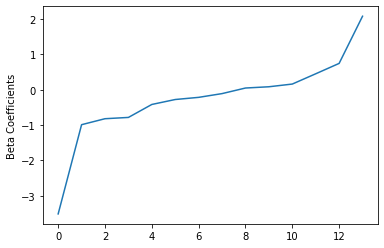

In [31]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

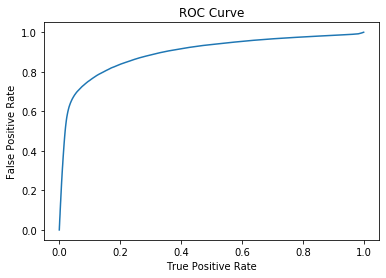

Training set areaUnderROC: 0.8948099563437487


In [32]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

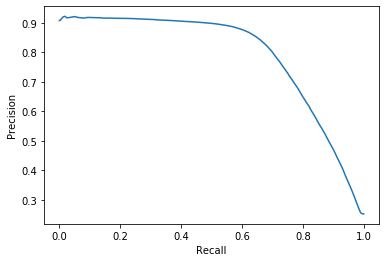

In [33]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [34]:
predictions = lrModel.transform(test)
predictions.select('AGE', 'SEX', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+---+-----+--------------------+----------+--------------------+
|AGE|SEX|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------------------+----------+--------------------+
| 49|  2|  0.0|[2.11386527691386...|       0.0|[0.89224352418184...|
| 27|  2|  0.0|[2.60791461031395...|       0.0|[0.93136921677110...|
| 50|  2|  0.0|[-0.6783595039405...|       1.0|[0.33662754261346...|
| 39|  2|  0.0|[0.65353656520567...|       0.0|[0.65780697644361...|
| 66|  2|  0.0|[-0.8033409278522...|       1.0|[0.30931131597191...|
| 40|  2|  0.0|[1.38407213015373...|       0.0|[0.79964420599489...|
| 31|  2|  0.0|[0.82818204310327...|       0.0|[0.69597039523828...|
| 28|  2|  0.0|[0.75050375826425...|       0.0|[0.67928845566999...|
| 33|  2|  0.0|[0.51791244828285...|       0.0|[0.62665949747979...|
| 36|  2|  0.0|[0.37835766229401...|       0.0|[0.59347693005993...|
+---+---+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8937702565410662


In [36]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('AGE', 'SEX', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+---+-----+------------------+----------+--------------------+
|AGE|SEX|label|     rawPrediction|prediction|         probability|
+---+---+-----+------------------+----------+--------------------+
| 49|  2|  0.0|[222515.0,14593.0]|       0.0|[0.93845420652192...|
| 27|  2|  0.0|[222515.0,14593.0]|       0.0|[0.93845420652192...|
| 50|  2|  0.0|  [16221.0,3786.0]|       0.0|[0.81076623181886...|
| 39|  2|  0.0|  [16221.0,3786.0]|       0.0|[0.81076623181886...|
| 66|  2|  0.0|  [15569.0,8553.0]|       0.0|[0.64542741066246...|
| 40|  2|  0.0|  [16221.0,3786.0]|       0.0|[0.81076623181886...|
| 31|  2|  0.0|  [16221.0,3786.0]|       0.0|[0.81076623181886...|
| 28|  2|  0.0|  [16221.0,3786.0]|       0.0|[0.81076623181886...|
| 33|  2|  0.0|  [16221.0,3786.0]|       0.0|[0.81076623181886...|
| 36|  2|  0.0|  [16221.0,3786.0]|       0.0|[0.81076623181886...|
+---+---+-----+------------------+----------+--------------------+
only showing top 10 rows



In [37]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6694405447695648


In [38]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('AGE', 'SEX', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+---+-----+--------------------+----------+--------------------+
|AGE|SEX|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------------------+----------+--------------------+
| 49|  2|  0.0|[14.6071795274353...|       0.0|[0.73035897637176...|
| 27|  2|  0.0|[14.0231493722025...|       0.0|[0.70115746861012...|
| 50|  2|  0.0|[10.6844651274047...|       0.0|[0.53422325637023...|
| 39|  2|  0.0|[14.8463572288204...|       0.0|[0.74231786144102...|
| 66|  2|  0.0|[10.8977154945461...|       0.0|[0.54488577472730...|
| 40|  2|  0.0|[14.2813006735131...|       0.0|[0.71406503367565...|
| 31|  2|  0.0|[14.2235742856055...|       0.0|[0.71117871428027...|
| 28|  2|  0.0|[14.2235742856055...|       0.0|[0.71117871428027...|
| 33|  2|  0.0|[13.2684155953568...|       0.0|[0.66342077976784...|
| 36|  2|  0.0|[12.8096117495233...|       0.0|[0.64048058747616...|
+---+---+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [39]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8990023075526982


In [40]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('AGE', 'SEX', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+---+-----+--------------------+----------+--------------------+
|AGE|SEX|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------------------+----------+--------------------+
| 49|  2|  0.0|[0.77933247466558...|       0.0|[0.82616169842744...|
| 27|  2|  0.0|[0.77868678914493...|       0.0|[0.82597615547140...|
| 50|  2|  0.0|[-0.1952398741550...|       1.0|[0.40360181640095...|
| 39|  2|  0.0|[0.88863171224808...|       0.0|[0.85535862524948...|
| 66|  2|  0.0|[0.05080968949905...|       0.0|[0.52538300537806...|
| 40|  2|  0.0|[0.68157849609232...|       0.0|[0.79627231260298...|
| 31|  2|  0.0|[0.60193722092020...|       0.0|[0.76921330797212...|
| 28|  2|  0.0|[0.60193722092020...|       0.0|[0.76921330797212...|
| 33|  2|  0.0|[0.60193722092020...|       0.0|[0.76921330797212...|
| 36|  2|  0.0|[0.60193722092020...|       0.0|[0.76921330797212...|
+---+---+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [41]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9003961999214344
